In [1]:
import datetime as dt
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from geopy import distance
from pandas.api.types import CategoricalDtype

In [2]:
# Create the day of week Category by iterrating over 7 days (March 4th, 2019 is a Monday)
days = [(dt.datetime(2019, 3, 4) + dt.timedelta(days=x)).strftime('%a') for x in range(0, 7)]
day_type = CategoricalDtype(categories=days, ordered=True)

# Create the month Category by iterrating over the months
months = [dt.datetime(2019, x, 1).strftime('%B') for x in range(1, 13)]
month_type = CategoricalDtype(categories=months, ordered=True)

In [3]:
df = pd.read_csv('./data/bikeshare_ridership.csv')

# Clean up column names for ease of use
df.columns = [' '.join(x.replace('trip_', '').replace('_seconds', '').split('_')).title() for x in df.columns]

In [4]:
df['Start Time'] = pd.to_datetime(df['Start Time'])
# df['Start Time'] = df['Start Time'].apply(lambda x: x - dt.timedelta(hours=4) if x.month < 7 else x)

df['Date'] = df['Start Time'].apply(lambda x: x.strftime('%Y-%m-%d'))
df['Quarter'] = df['Start Time'].apply(lambda x: int((int(x.strftime('%m')) - 1) / 3) + 1)
df['Month'] = df['Start Time'].apply(lambda x: x.strftime('%B')).astype(month_type)
df['Day of Week'] = df['Start Time'].apply(lambda x: x.strftime('%a')).astype(day_type)
df['Hour'] = df['Start Time'].apply(lambda x: x.strftime('%H'))

# Create a "Route ID" in the "[start station ID]-[end station ID]" format
df['Route Id'] = df.apply(lambda x: '{0}-{1}'.format(int(x['Station Id From']), int(x['Station Id To'])), axis=1)

In [5]:
# Extract the unique routes from the data with their start and end coordinates
maps = df[['Route Id', 'Station Id From', 'Lat From', 'Lon From', 'Station Id To', 'Lat To', 'Lon To']].drop_duplicates()
maps['Distance'] = maps.apply(lambda x: distance.distance((x['Lat From'], x['Lon From']), (x['Lat To'], x['Lon To'])).km * 1000, axis=1)

In [6]:
# Merge the distance calculation with the main DataFrame
df = df.merge(maps[['Route Id', 'Distance']], how='left', on='Route Id')
df = df[[x for x in df.columns if not 'From' in x and not 'To' in x and x != 'Route Id']]

In [7]:
df.sample(10)

,Id,Start Time,Duration,User Type,Date,Quarter,Month,Day of Week,Hour,Distance
752417,2189199,2017-11-03 12:06:03,475,Member,2017-11-03,4,November,Fri,12,1808.451867
33146,2116432,2017-10-22 00:27:43,465,Member,2017-10-22,4,October,Sun,00,839.329280
397380,1425525,2017-07-24 16:42:00,537,Casual,2017-07-24,3,July,Mon,16,1304.636883
64124,1024464,2017-05-19 00:22:00,284,Member,2017-05-19,2,May,Fri,00,729.022255
32911,2142318,2017-10-25 18:41:04,141,Member,2017-10-25,4,October,Wed,18,324.097151
244144,1865333,2017-09-18 12:03:00,344,Member,2017-09-18,3,September,Mon,12,688.202327
973355,1509259,2017-08-04 08:04:00,1898,Member,2017-08-04,3,August,Fri,08,3641.755930
1026335,1318729,2017-07-10 08:52:00,203,Member,2017-07-10,3,July,Mon,08,613.172702
88824,2348293,2017-12-10 10:19:06,692,Member,2017-12-10,4,December,Sun,10,1841.282833
1322046,2051967,2017-10-12 16:40:26,1334,Member,2017-10-12,4,October,Thu,16,4741.984916


In [36]:
# Set default visualization styles
sns.set_style('dark')

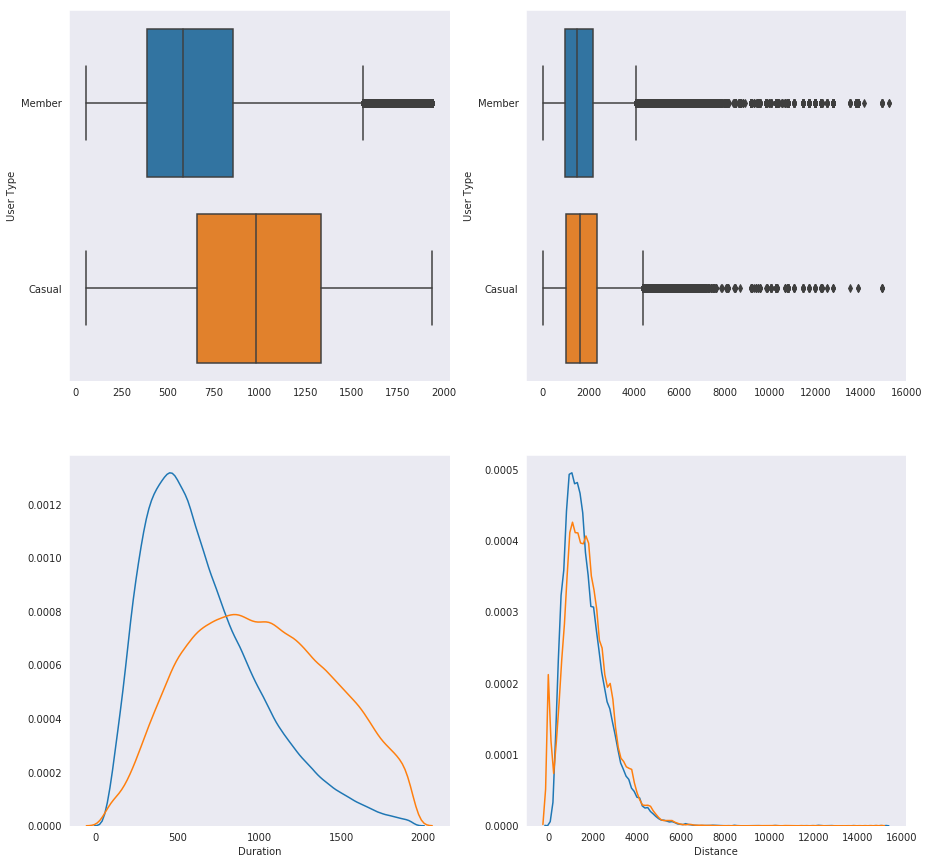

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(15, 15))

for i, col in enumerate(['Duration', 'Distance']):
    # Graph the distribution plots (seaborn doesn't allow default separation for distplot)
    for j, user in enumerate(df['User Type'].unique()):
        sns.distplot(df[df['User Type']==user][col], hist=False, ax=ax2[i])
    
    # Graph the boxplots
    sns.boxplot(x=col, y='User Type', data=df, ax=ax1[i])
    ax1[i].set_xlabel('')

plt.savefig('./visualization/distributions.png')

In [10]:
# Aggregate the ridership by date fields and user type and count the number of unique trips
ridership = df.groupby(['Date', 'Quarter', 'Month', 'Day of Week', 'User Type'])['Id'].nunique().reset_index().sort_values('User Type', ascending=False)

In [11]:
ridership.sample(10)

,Date,Quarter,Month,Day of Week,User Type,Id
488,2017-09-01,3,September,Fri,Casual,1192
170,2017-03-26,1,March,Sun,Casual,71
182,2017-04-01,2,April,Sat,Casual,288
150,2017-03-16,1,March,Thu,Casual,39
175,2017-03-28,1,March,Tue,Member,2569
12,2017-01-06,1,January,Fri,Casual,32
596,2017-10-25,4,October,Wed,Casual,410
177,2017-03-29,1,March,Wed,Member,2594
46,2017-01-23,1,January,Mon,Casual,30
434,2017-08-05,3,August,Sat,Casual,1855


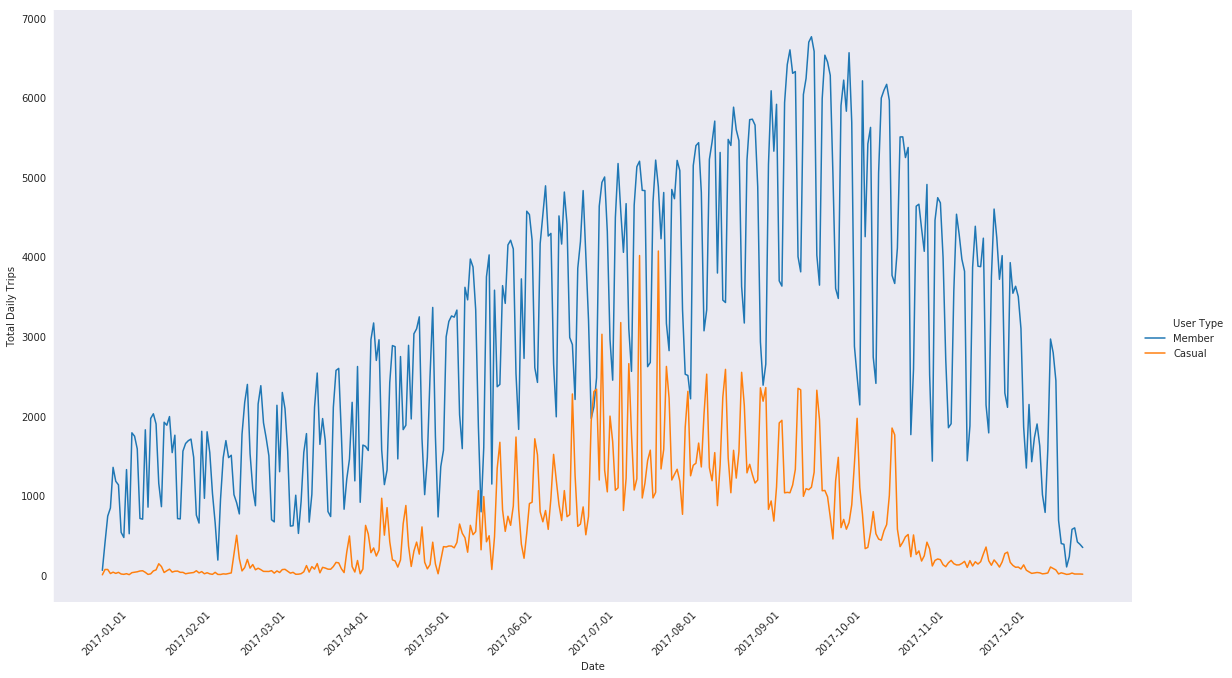

In [12]:
p = sns.relplot(x='Date', y='Id', hue='User Type', data=ridership, kind='line', height=9, aspect=16/9.)
p.ax.set_ylabel('Total Daily Trips')

# Limit the number of labels shown on the x-axis to only show the first day of each month
p.ax.set_xticklabels([x.set_text('') if not x.get_text().endswith('-01') else x for x in p.ax.get_xticklabels()], rotation=45)

plt.savefig('./visualization/ridership.png')

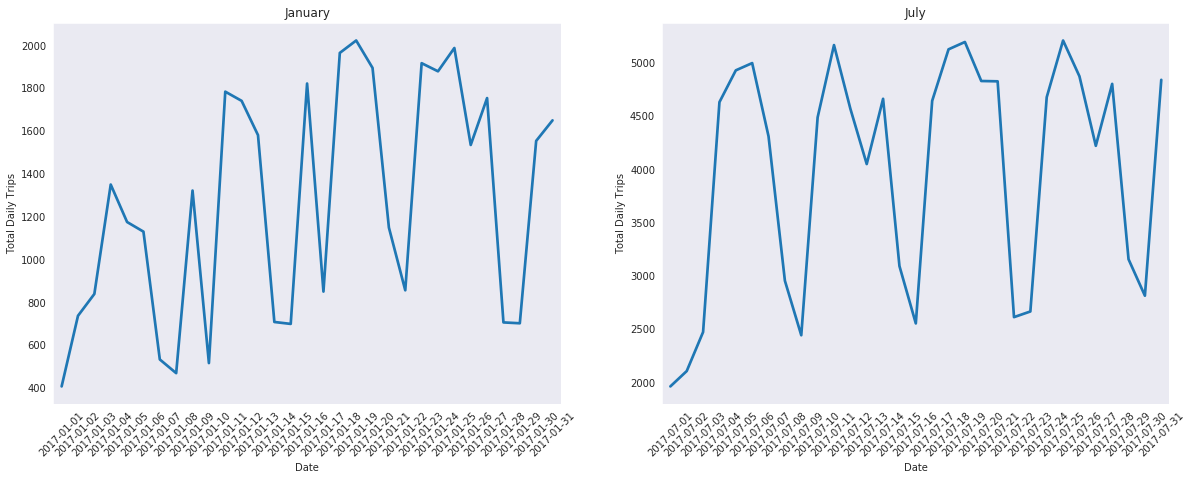

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

for ax, m in zip(axes, ['January', 'July']):
    sns.pointplot(x='Date', y='Id', data=ridership[(ridership['Month']==m)&(ridership['User Type']=='Member')].groupby('Date')['Id'].sum().reset_index(), ax=ax, markers='')
    
    ax.set_title(m)
    ax.set_ylabel('Total Daily Trips')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.savefig('./visualization/ridership_selection.png')

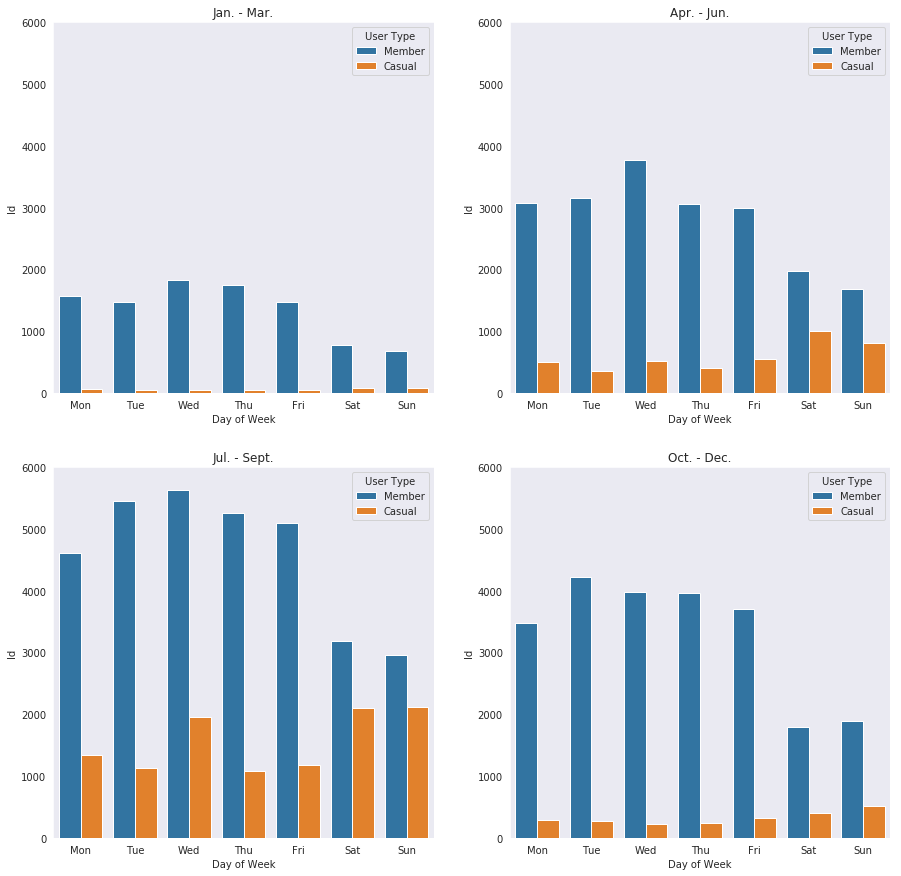

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = np.array(axes).flatten()                                               # Flatten the 2D axes array for ease of looping
quarter_names = ['Jan. - Mar.', 'Apr. - Jun.', 'Jul. - Sept.', 'Oct. - Dec.'] # Prepare the month description titles for each quarter

for q, ax in zip(sorted(ridership['Quarter'].unique()), axes):
    ax.set_title(quarter_names[(q-1)])
    
    # Set the y-axis range for consistency across the four graphs
    ax.set_ylim(0, 6000)
    ax.set_ylabel('Average Daily Trips')
    
    viz = ridership[ridership['Quarter']==q].groupby(['Day of Week', 'User Type'])['Id'].mean().reset_index().sort_values('User Type', ascending=False)
    
    sns.barplot(
        x='Day of Week', 
        y='Id', 
        hue='User Type', 
        data=viz, 
        ax=ax
    )

plt.savefig('./visualization/quarterly.png')

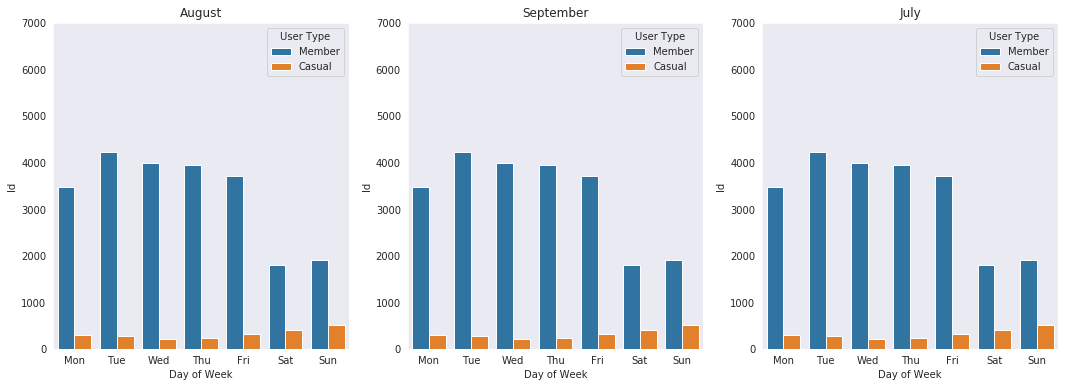

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes = np.array(axes).flatten()

for m, ax in zip(ridership[ridership['Quarter']==3]['Month'].unique(), axes):
    ax.set_title(m)
    ax.set_ylim(0, 7000)
    ax.set_ylabel('Average Daily Trips')
    
    viz = ridership[ridership['Quarter']==q].groupby(['Day of Week', 'User Type'])['Id'].mean().reset_index().sort_values('User Type', ascending=False)

    
    sns.barplot(
        x='Day of Week', 
        y='Id', 
        hue='User Type', 
        data=viz, 
        ax=ax
    )
    
plt.savefig('./visualization/third_quarter.png')

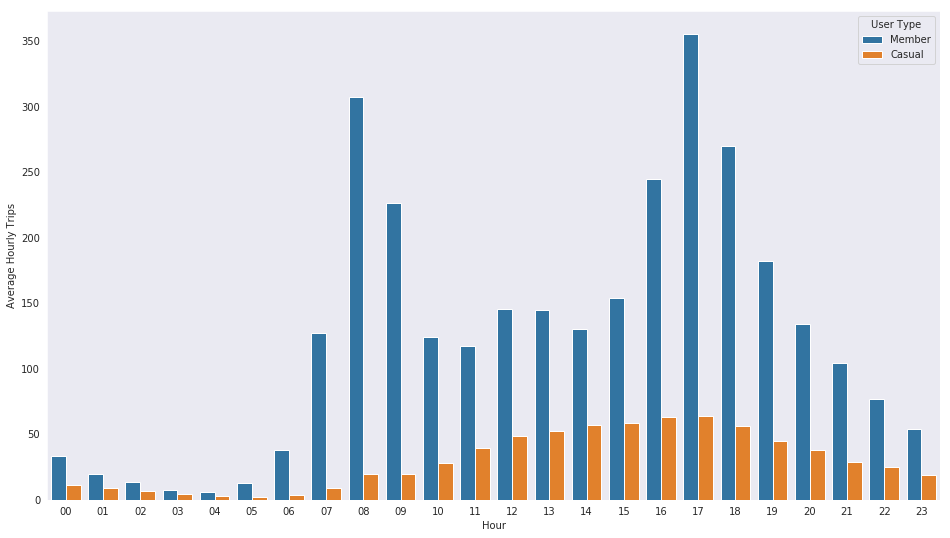

In [17]:
data = df.groupby(['Date', 'Hour', 'User Type'])['Id'].nunique().groupby(['Hour', 'User Type']).mean().reset_index().sort_values('User Type', ascending=False)

fig, ax = plt.subplots(figsize=(16, 9))

sns.barplot(x='Hour', y='Id', hue='User Type', data=data, ax=ax)
ax.set_ylabel('Average Hourly Trips')

plt.savefig('./visualization/hourly.png')

In [20]:
# Import the weather data and drop the first 22 rows (containing descriptions of the weather station)
weather = pd.read_csv('./data/weather.csv', header=22)
# Remove units contained in the column names (eg. Celcius, mm, etc.)
weather.columns = [re.sub(r'\([^()]*\)', '', x).strip() if x != 'Date/Time' else 'Date' for x in weather.columns]

In [39]:
data = df.groupby(['Date', 'User Type'])['Id'].nunique().to_frame().pivot_table(index='Date', columns='User Type').reset_index()
data.columns = ['Date', 'Casual Trips', 'Member Trips']

data = data.merge(weather[['Date', 'Mean Temp', 'Total Precip']], on='Date', how='inner')

In [22]:
data.sample(10)

,Date,Casual Trips,Member Trips,Mean Temp,Total Precip
197,2017-07-17,1066,4645,22.5,0.0
348,2017-12-15,26,1620,-6.4,0.5
141,2017-05-22,984,1602,NaN,NaN
24,2017-01-25,72,1989,3.4,2.6
258,2017-09-16,2344,3998,21.6,0.0
289,2017-10-17,436,5991,11.7,0.0
33,2017-02-03,30,1477,-5.7,0.0
181,2017-07-01,1930,1966,21.2,3.2
183,2017-07-03,2333,2476,20.3,0.0
45,2017-02-15,10,1687,-1.1,0.0


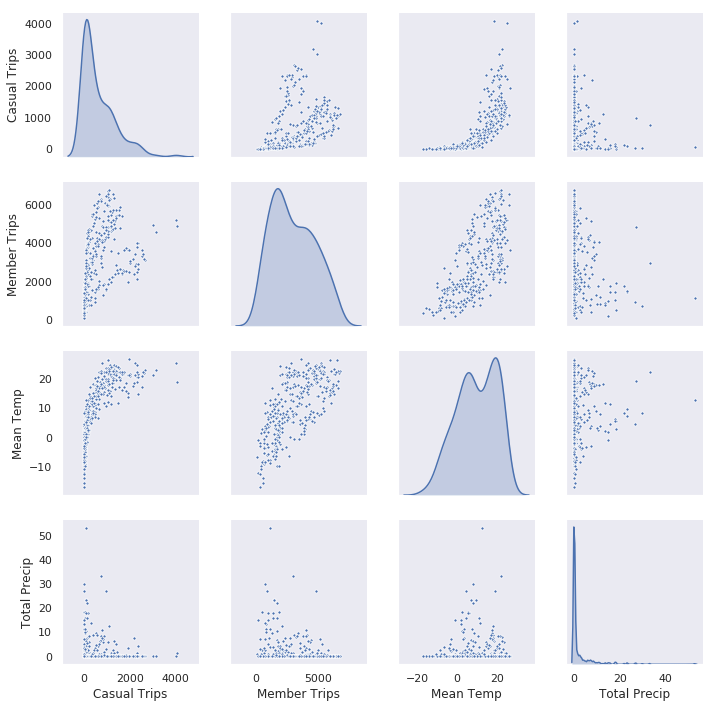

In [37]:
g = sns.pairplot(data, diag_kind='kde', plot_kws={'s': 10})
g.fig.set_size_inches(10, 10)

g.savefig('./visualization/pair.png')

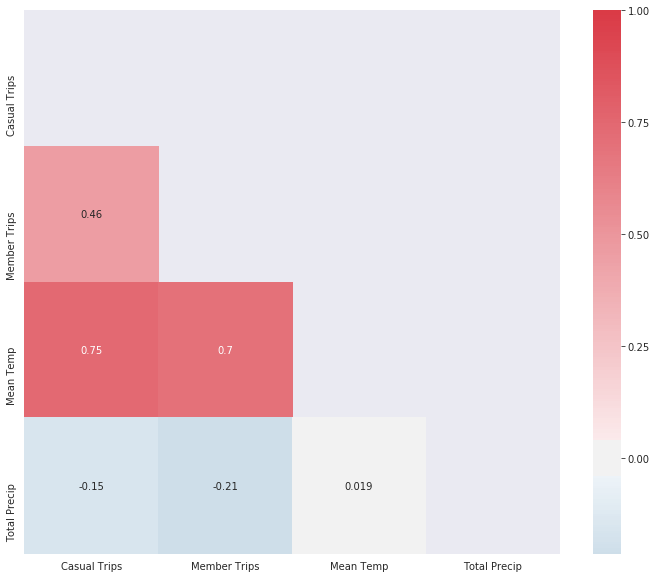

In [29]:
fig, ax = plt.subplots(figsize=(12, 10))

corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, annot=True, cmap=sns.diverging_palette(240, 10, as_cmap=True), center=0)

plt.savefig('./visualization/heatmap.png')

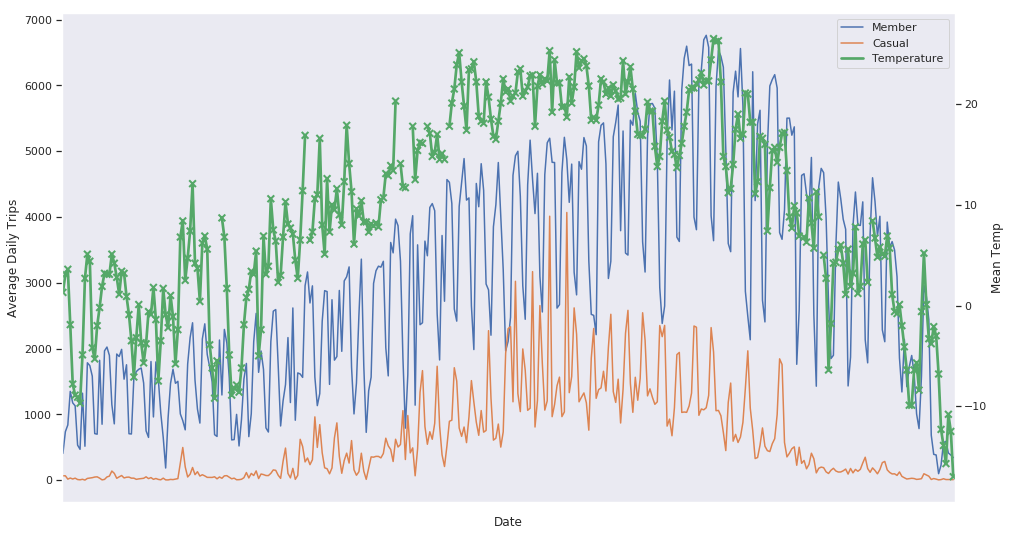

In [40]:
fig, ax = plt.subplots(figsize=(16, 9))
ax2 = ax.twinx()              # Create the twin axis to enable display of ridership and temperature on the same graph
palette = sns.color_palette() # Get the default color palette

for i, user_type in enumerate(['Member Trips', 'Casual Trips']):
    sns.lineplot(x='Date', y=user_type, data=data, ax=ax, color=palette[i], markers='')
    
sns.pointplot(x='Date', y='Mean Temp', data=data, ax=ax2, color=palette[2], markers='x')

ax.set_ylabel('Average Daily Trips')
ax.set_xticklabels([x.set_text('') if not x.get_text().endswith('-01') else x for x in ax.get_xticklabels()], rotation=45)

# Create the legend (due to the way this graph is created the default legend is not correct)
ax.legend(handles=ax.lines + ax2.lines, labels=['Member', 'Casual', 'Temperature'])
plt.savefig('./visualization/temperature.png')

In [29]:
data = data.sort_values('Mean Temp').dropna().reset_index(drop=True)

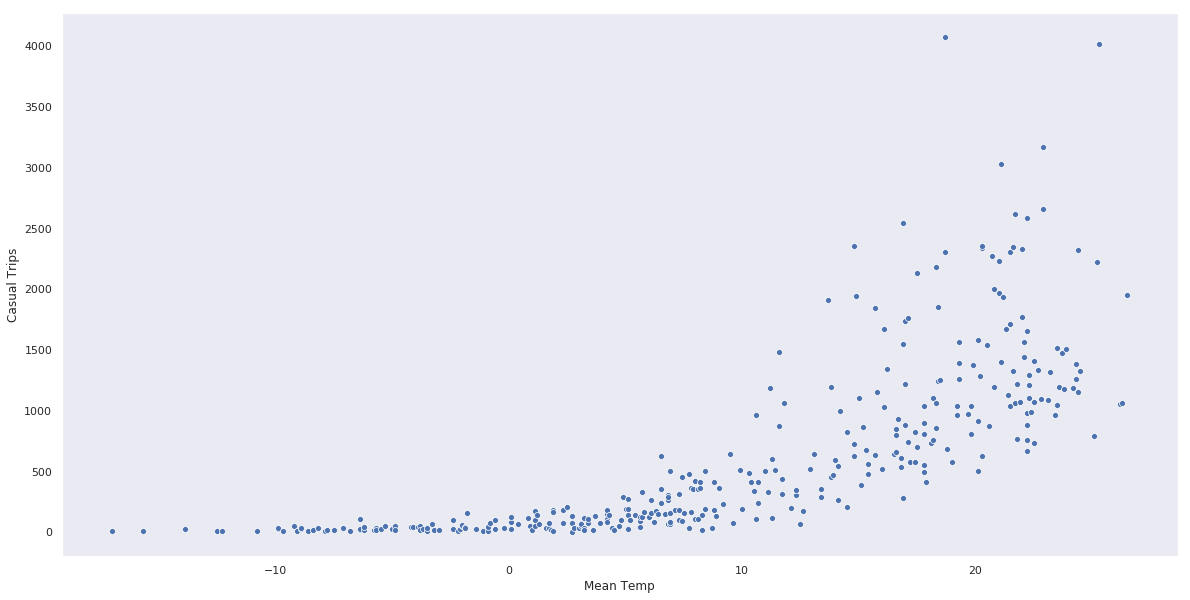

In [30]:
fig, ax = plt.subplots(figsize=(20, 10))

sns.scatterplot(x='Mean Temp', y='Casual Trips', data=data)
plt.savefig('./visualization/fit_0.png')

In [31]:
from kneed import KneeLocator
from scipy.optimize import curve_fit

# Define the curve fitting equations
def linear(x, m, b):
    return m*x + b

def exp_growth_no_shift(x, a, b):
    return a * np.exp(-b * x)

def exp_growth(x, a, b, c):
    return a * np.exp(-b * x) + c

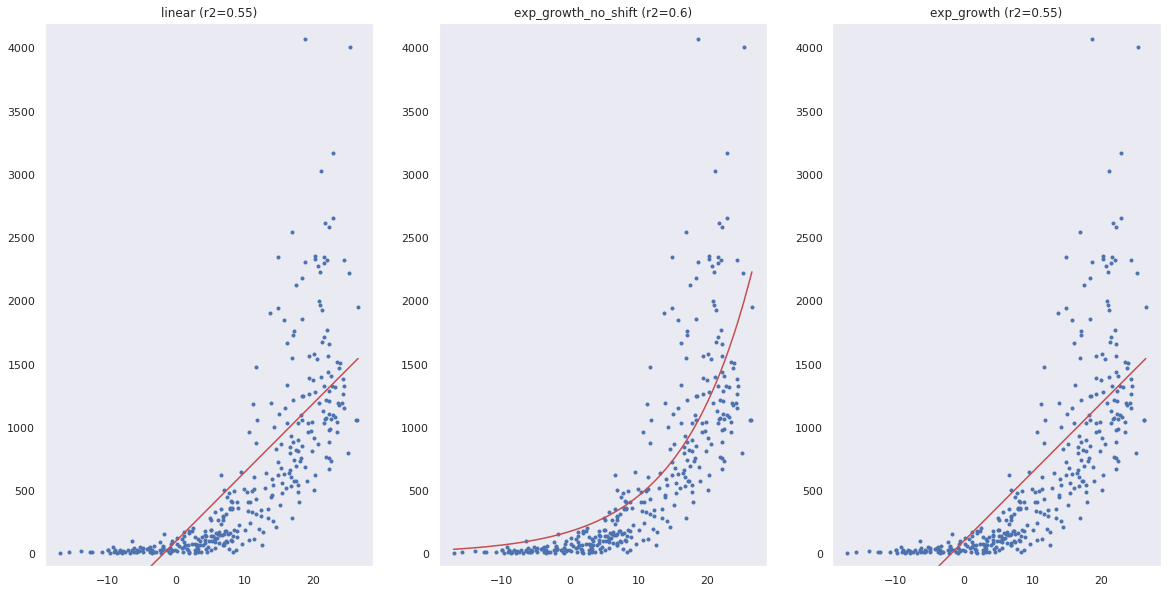

In [32]:
x = data['Mean Temp'].values
y = data['Casual Trips'].values

# Estimate curve for each of the method used and graph the fitted curve
fig, axes = plt.subplots(1, 3, figsize=(20, 10))
for ax, func in zip(axes, [linear, exp_growth_no_shift, exp_growth]):
    popt, pcov = curve_fit(func, x, y, maxfev=2000)
    y_fit = func(x, *popt)
    
    r2 = 1 - (np.sum((y - y_fit) ** 2) / np.sum((y - np.mean(y)) ** 2))

    ax.plot(x, y, '.')
    ax.plot(x, y_fit, 'r-')
    ax.set_ylim(-100, 4200)
    ax.set_title('{0} (r2={1})'.format(func.__name__, np.round(r2, 2)))

plt.savefig('./visualization/fig_1.png')

In [33]:
popt, pcov = curve_fit(exp_growth_no_shift, x, y, maxfev=2000)

# Estimate the first knee point
kneedle = KneeLocator(x=x, y=exp_growth_no_shift(x, *popt), curve='convex', direction='increasing')
knee_start = kneedle.knee

print(knee_start)

16.1


In [32]:
def logistic_growth(x, k, x0):
    return 1 / (1 + np.exp(-k*(x - x0)))

In [33]:
data['Cummulative Trips'] = data['Casual Trips'].cumsum()
data['Percentage Trips'] = data['Cummulative Trips'] / data['Casual Trips'].sum()

In [34]:
x = data['Mean Temp'].values
y = data['Percentage Trips'].values

popt, pcov = curve_fit(logistic_growth, x, y, maxfev=2000)
y_fit = logistic_growth(x, *popt)

In [35]:
kneedle = KneeLocator(x=x, y=y_fit, curve='convex', direction='increasing')
knee_start = kneedle.knee

print(knee_start)

16.0


In [36]:
for idx, val in enumerate(x):
    if val > knee_start:
        kneedle = KneeLocator(x=x[idx:], y=y_fit[idx:], curve='concave', direction='increasing')
        knee_end = kneedle.knee
        
        print(knee_end)
        break

21.6
